# Vehicle Detection & Tracking
### Author: Bryce Freshcorn

In [1]:
%matplotlib inline
from collections import deque
import cv2
from glob import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import pandas as pd
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

## Helper Functions

In [2]:
def read_video_dir(img_dir, extension):
    driving_files = glob(join(img_dir,'*.{}'.format(extension)))
    return np.array([mpimg.imread(file) for file in driving_files])

In [3]:
def read_imgs(data_dir):
    imgs = []
    img_files = glob(join(data_dir, '*/*.png'))
    for file in img_files:
        imgs.append(mpimg.imread(file))
    return imgs

## Lesson Functions

In [4]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features
# Need to change bins_range if reading .png files with mpimg
def color_hist(img, nbins=32): # bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins) # , range=bins_range
    channel2_hist = np.histogram(img[:,:,1], bins=nbins) # , range=bins_range
    channel3_hist = np.histogram(img[:,:,2], bins=nbins) # , range=bins_range
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = window // pix_per_cell - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    return draw_img, heatmap

## Process Data

In [5]:
test_video_dir = './test_images'
vehicle_data_dir = './data/vehicles'
non_vehicle_data_dir = './data/non-vehicles'

In [6]:
vehicle_imgs = read_imgs(vehicle_data_dir)
non_vehicle_imgs = read_imgs(non_vehicle_data_dir)

## Step I - Train Classifier on HOG Features

In [7]:
view_indices = np.random.randint(0, len(vehicle_imgs), size=10)

#### HOG Comparison

In [8]:
spatial_size = (32, 32)
orient = 12
pix_per_cell = 8
cell_per_block = 2
hist_bins = 32
color_space = 'YCrCb'

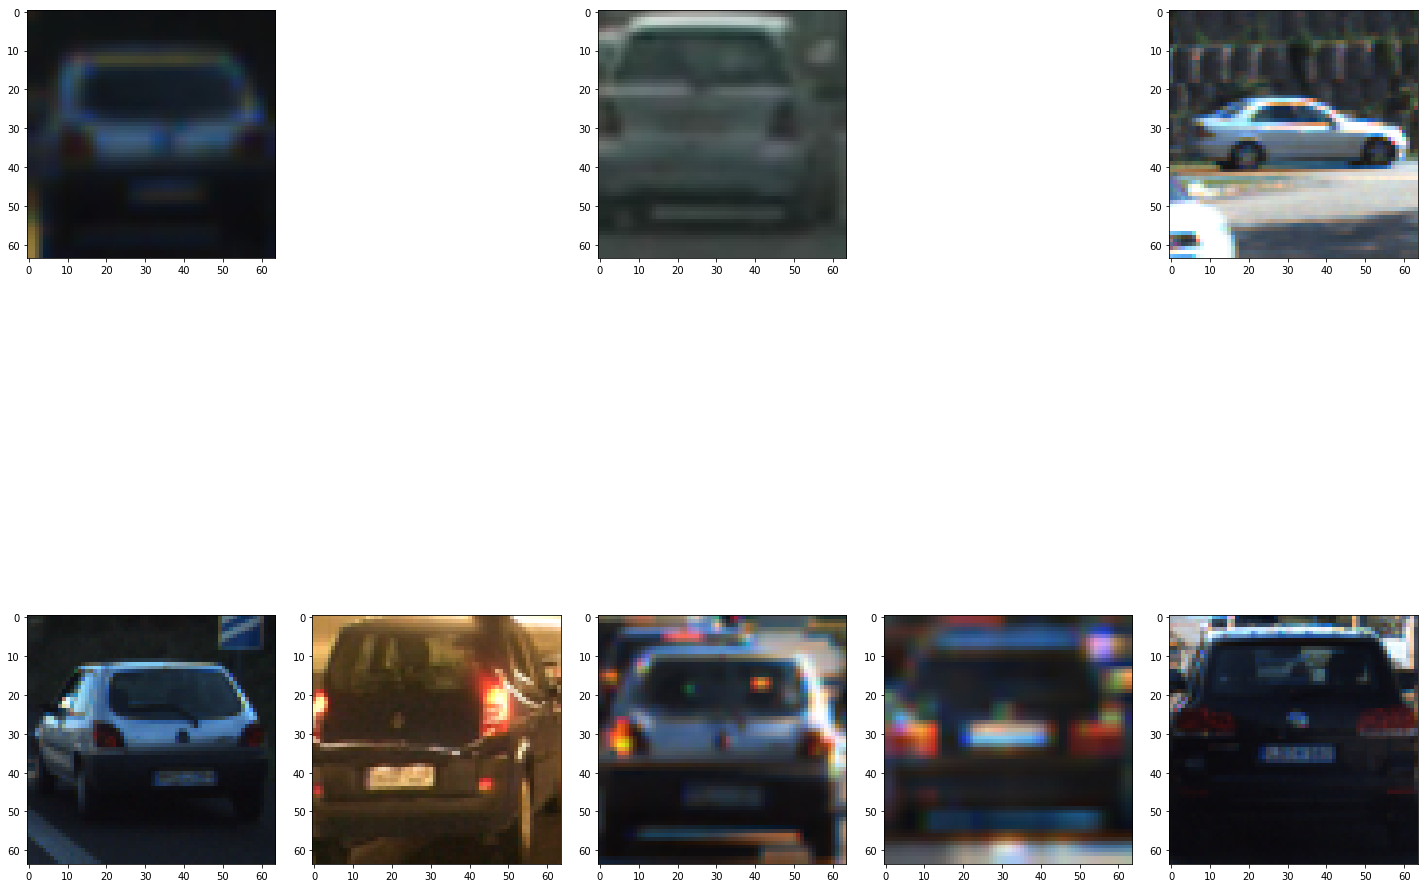

In [9]:
plt.figure(figsize=(20,20))
for i, index in enumerate(view_indices, start=1):
    plt.subplot(2, 5, i)
    plt.tight_layout()
    plt.imshow(vehicle_imgs[index])

/home/bryce/anaconda3/envs/carnd-term1/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


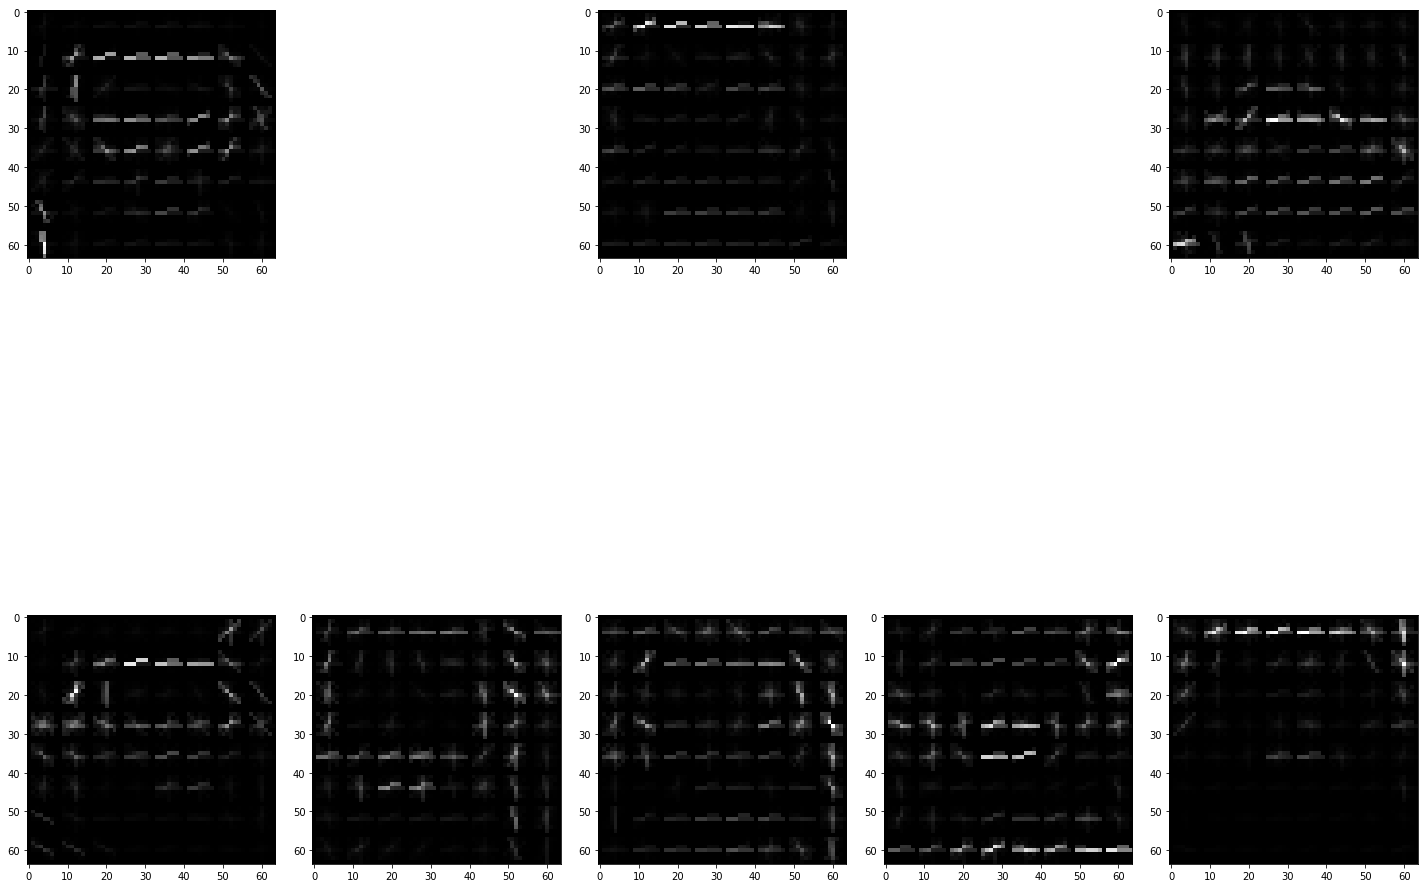

In [10]:
plt.figure(figsize=(20,20))
for i, index in enumerate(view_indices, start=1):
    plt.subplot(2, 5, i)
    plt.tight_layout()
    gray = cv2.cvtColor(vehicle_imgs[index], cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(gray, orient=orient, pix_per_cell= pix_per_cell,
                                           cell_per_block=cell_per_block, vis=True, feature_vec=False)
    plt.imshow(hog_image, cmap='gray')

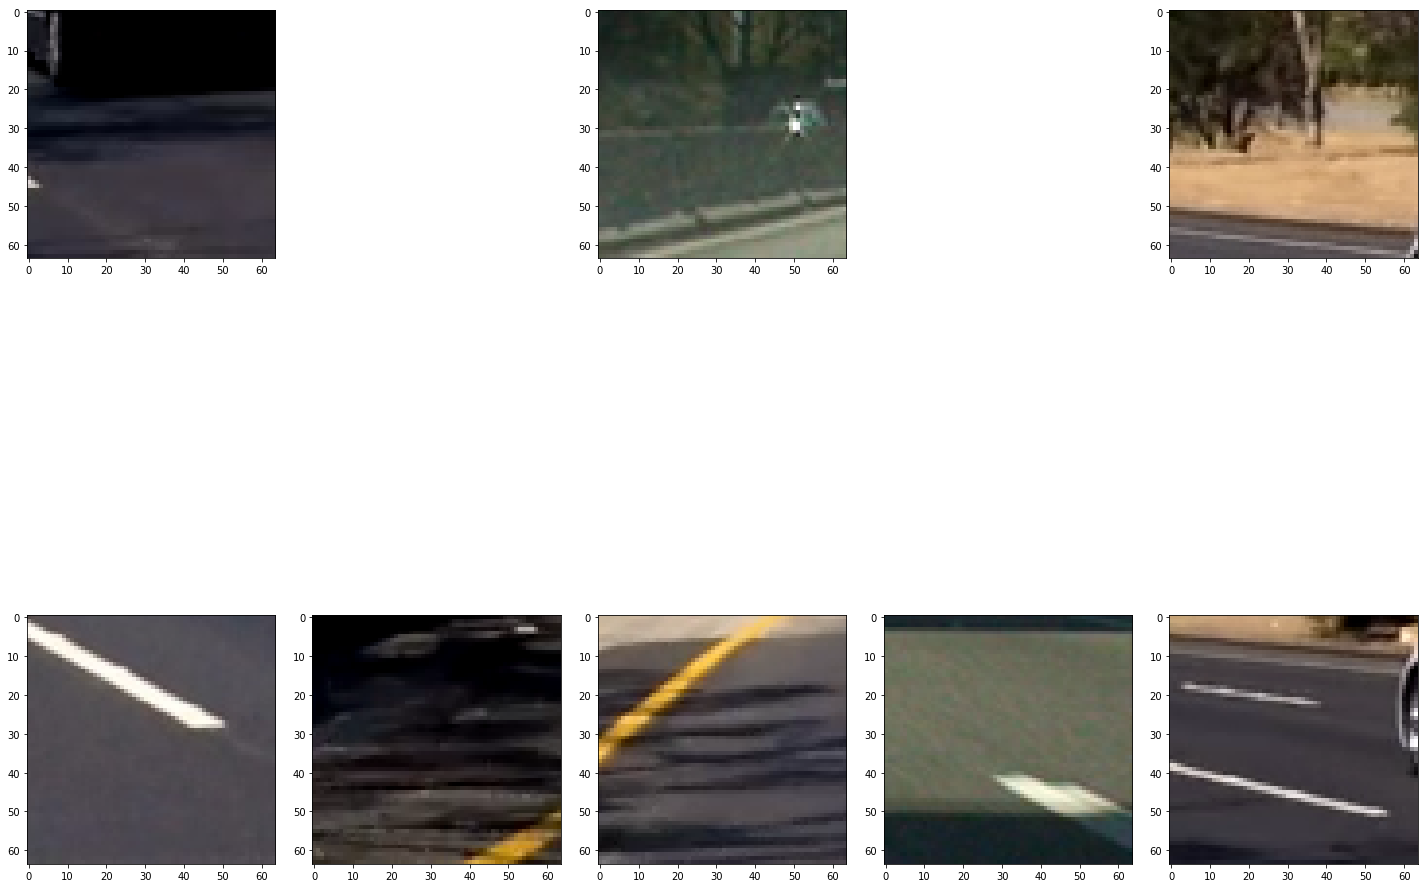

In [11]:
plt.figure(figsize=(20,20))
for i, index in enumerate(view_indices, start=1):
    plt.subplot(2, 5, i)
    plt.tight_layout()
    plt.imshow(non_vehicle_imgs[index])

/home/bryce/anaconda3/envs/carnd-term1/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


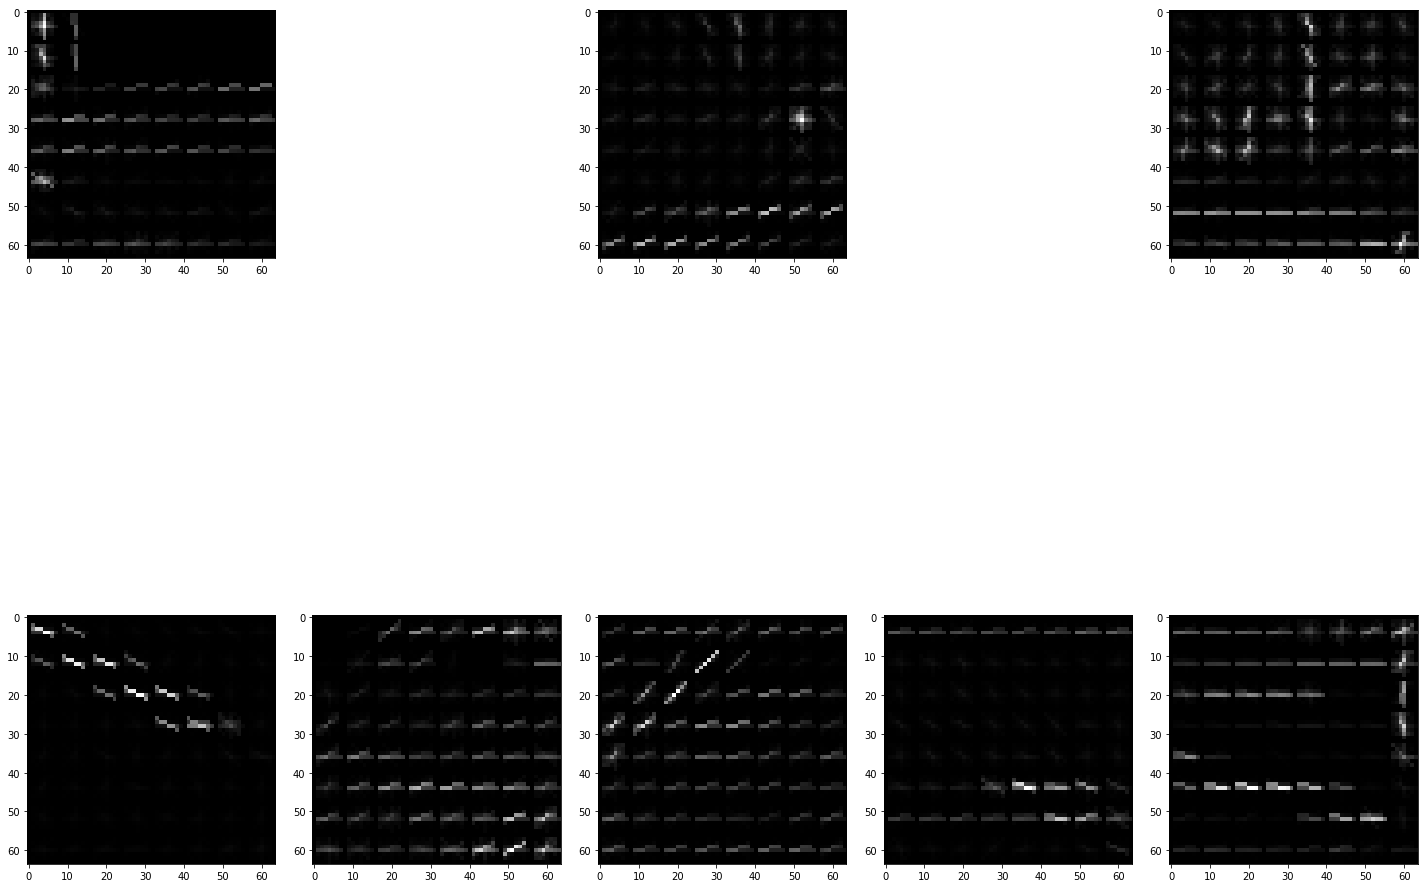

In [12]:
plt.figure(figsize=(20,20))
for i, index in enumerate(view_indices, start=1):
    plt.subplot(2, 5, i)
    plt.tight_layout()
    gray = cv2.cvtColor(non_vehicle_imgs[index], cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(gray, orient=orient, pix_per_cell= pix_per_cell,
                                           cell_per_block=cell_per_block, vis=True, feature_vec=False)
    plt.imshow(hog_image, cmap='gray')

In [13]:
vehicle_features = extract_features(vehicle_imgs, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel='ALL', spatial_feat=True, 
                                    hist_feat=True, hog_feat=True)
non_vehicle_features = extract_features(non_vehicle_imgs, color_space=color_space, 
                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                        orient=orient, pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, 
                                        hog_channel='ALL', spatial_feat=True, 
                                        hist_feat=True, hog_feat=True)

/home/bryce/anaconda3/envs/carnd-term1/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [14]:
X_data = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
y_data = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, stratify=y_data)

In [16]:
scaler = StandardScaler()
norm_X_train = scaler.fit_transform(X_train)
norm_X_test = scaler.transform(X_test)

In [17]:
svc = LinearSVC(verbose=3)
svc.fit(norm_X_train, y_train)

[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=3)

In [18]:
from sklearn.externals import joblib
joblib_model = {'svc': svc,
                'scaler': scaler,
                'spatial_size': spatial_size,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hist_bins': hist_bins,
                'color_space': color_space}
joblib.dump(joblib_model, 'classifier.pkl')

['classifier.pkl']

In [19]:
joblib_model = joblib.load('classifier.pkl')
svc = joblib_model['svc']
scaler = joblib_model['scaler']
spatial_size = joblib_model['spatial_size']
orient = joblib_model['orient']
pix_per_cell = joblib_model['pix_per_cell']
cell_per_block = joblib_model['cell_per_block']
hist_bins = joblib_model['hist_bins']
color_space = joblib_model['color_space']

In [20]:
from sklearn.metrics import f1_score, accuracy_score
f1_score(y_test, svc.predict(norm_X_test))

0.992018244013683

In [21]:
accuracy_score(y_test, svc.predict(norm_X_test))

0.9921171171171171

In [22]:
historical_imgs = deque(maxlen=20) 

def process_img(driving_img):
    ystart = 400 
    ystop = 528
    scale = 1
    out_img, heat_map = find_cars(driving_img, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    historical_imgs.append(heat_map)
    
    ystart = 400 
    ystop = 656
    scale = 1.5
    out_img, heat_map = find_cars(driving_img, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat_map = apply_threshold(heat_map, 1)
    historical_imgs.append(heat_map)
    
    if len(historical_imgs) < 20:
        labels = label(heat_map)
    else:
        heatmap_sum = sum(historical_imgs)
        heatmap_sum = np.clip(heatmap_sum, 0, 255)
        labels = label(heatmap_sum)
        
    draw_img = draw_labeled_bboxes(np.copy(driving_img), labels)
    return draw_img

In [23]:
from moviepy.editor import VideoFileClip
project_video = VideoFileClip('project_video.mp4')
processed_video = project_video.fl_image(process_img)
processed_video.write_videofile('output_video.mp4', audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [14:53<00:00,  1.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

